# 03 - DAG Execution: Parallelization for Speed

In the previous notebook, we optimized context with vector search.

Now let's see how **DAG-based execution** enables parallel task execution for significant speedups.

## Learning Objectives

After this notebook, you will:

- [ ] Understand what a DAG (Directed Acyclic Graph) is
- [ ] Learn about dependencies, layers, and fan-in/fan-out patterns
- [ ] See parallel execution achieve real speedups
- [ ] Practice identifying parallelization opportunities

---

## What is a DAG?

A **DAG** (Directed Acyclic Graph) is a graph where:
- **Directed**: Edges have a direction (A → B means A must complete before B)
- **Acyclic**: No cycles (you can't go from A back to A)

### Why DAGs for Workflows?

Workflows have **dependencies** between tasks:
- `read_config` must complete before other tasks use the config
- `fetch_github` and `fetch_slack` can run in **parallel** (both depend only on config)
- `process_data` must **wait** for both fetches (fan-in pattern)

### Key Patterns

| Pattern     | Description                           | Example                        |
| ----------- | ------------------------------------- | ------------------------------ |
| **Fan-out** | One task feeds many parallel tasks    | A → [B, C, D]                  |
| **Fan-in**  | Many tasks feed into one merge point  | [B, C] → D                     |
| **Linear**  | Sequential dependency chain           | A → B → C                      |
| **Layer**   | Tasks at same depth execute together  | [B, C] are at the same layer   |

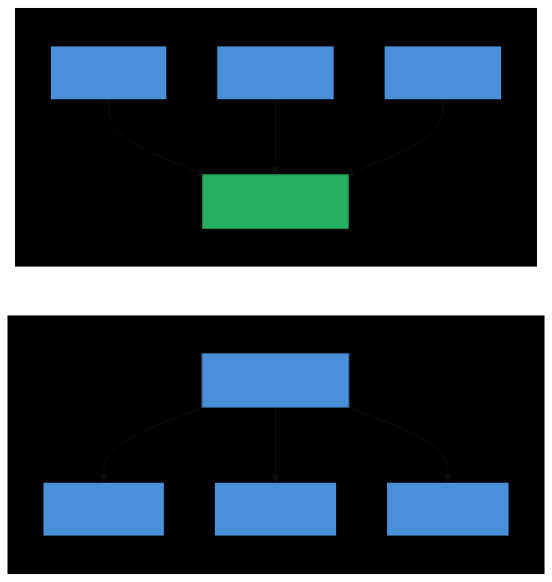

In [24]:
// Visualize fan-in and fan-out patterns
import { displayMermaid } from "../lib/viz.ts";

const patternsDiagram = `
%%{init: {'theme': 'base', 'themeVariables': { 'primaryColor': '#4a90d9', 'primaryTextColor': '#fff'}}}%%
graph LR
    subgraph FanOut["Fan-Out Pattern"]
        X["Single Input"] --> Y1["Branch 1"]
        X --> Y2["Branch 2"]
        X --> Y3["Branch 3"]
    end
    
    subgraph FanIn["Fan-In Pattern"]
        Z1["Result 1"] --> W["Merge Point"]
        Z2["Result 2"] --> W
        Z3["Result 3"] --> W
    end
    
    style X fill:#4a90d9,stroke:#2d5a87,color:#fff
    style W fill:#27ae60,stroke:#1e8449,color:#fff
`;

await displayMermaid(patternsDiagram);

## Layers: The Key to Parallelization

A **topological sort** organizes tasks into **layers**:
- **Layer 0**: Tasks with no dependencies (entry points)
- **Layer N**: Tasks whose dependencies are ALL in layers 0 to N-1

### The Rule
> All tasks in the same layer can execute **in parallel**.

Let's see this with our example workflow.

══════════════════════════════════════════════════
         EXAMPLE WORKFLOW
══════════════════════════════════════════════════

DAG Stats:
  - Total tasks: 5
  - Entry points: 1
  - With dependencies: 4
  - Workflow ID: demo-workflow

Workflow visualization:



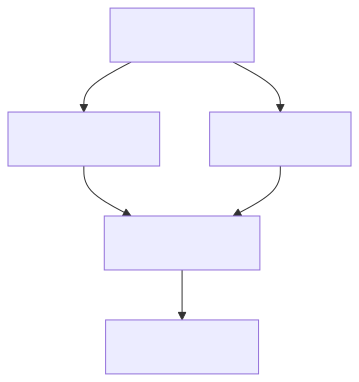

In [25]:
// Define our example DAG workflow
import { type DAGTask, type DAGWorkflow, dagStats, displayDag } from "../lib/viz.ts";

// A realistic workflow with parallelization opportunities
const exampleDAG: DAGWorkflow = {
  id: "demo-workflow",
  tasks: [
    { id: "A", tool_name: "read_config", dependencies: [] },
    { id: "B", tool_name: "fetch_github", dependencies: ["A"] },
    { id: "C", tool_name: "fetch_slack", dependencies: ["A"] },
    { id: "D", tool_name: "process_data", dependencies: ["B", "C"] },
    { id: "E", tool_name: "create_ticket", dependencies: ["D"] },
  ]
};

console.log("═".repeat(50));
console.log("         EXAMPLE WORKFLOW");
console.log("═".repeat(50));
console.log();
console.log(dagStats(exampleDAG));
console.log();
console.log("Workflow visualization:");
console.log();

// Display the DAG as a Mermaid diagram
await displayDag(exampleDAG);

## Topological Sort: Organizing into Layers

The algorithm works by finding tasks whose dependencies are already satisfied:

══════════════════════════════════════════════════
         TOPOLOGICAL SORT RESULT
══════════════════════════════════════════════════

Layer 0: A(read_config)
Layer 1: B(fetch_github), C(fetch_slack) [PARALLEL]
Layer 2: D(process_data)
Layer 3: E(create_ticket)

Visualization with layers:



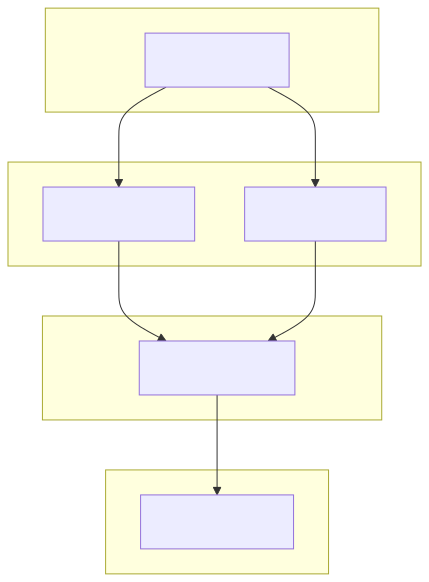

In [26]:
// Topological sort implementation - organizes tasks into parallel layers
import { type DAGTask, type DAGWorkflow, displayLayers } from "../lib/viz.ts";

function topologicalSort(dag: DAGWorkflow): DAGTask[][] {
  const layers: DAGTask[][] = [];
  const completed = new Set<string>();
  const remaining = [...dag.tasks];

  while (remaining.length > 0) {
    // Find tasks whose dependencies are all completed
    const layer = remaining.filter(task =>
      (task.dependencies || []).every(dep => completed.has(dep))
    );

    if (layer.length === 0) {
      throw new Error("Cycle detected in DAG!");
    }

    layers.push(layer);
    
    // Mark layer tasks as completed and remove from remaining
    layer.forEach(task => {
      completed.add(task.id);
      const idx = remaining.indexOf(task);
      remaining.splice(idx, 1);
    });
  }

  return layers;
}

// Apply topological sort to our workflow
const layers = topologicalSort(exampleDAG);

console.log("═".repeat(50));
console.log("         TOPOLOGICAL SORT RESULT");
console.log("═".repeat(50));
console.log();

for (let i = 0; i < layers.length; i++) {
  const layer = layers[i];
  const tasks = layer.map(t => `${t.id}(${t.tool_name})`).join(", ");
  const parallel = layer.length > 1 ? " [PARALLEL]" : "";
  console.log(`Layer ${i}: ${tasks}${parallel}`);
}

console.log();
console.log("Visualization with layers:");
console.log();

// Display layers as subgraphs
await displayLayers(layers);

## Live Demo: Sequential vs Parallel Execution

Now let's execute the workflow both ways and measure the real time difference!

### Task Durations (simulating real API calls)

| Task         | Duration | Why?               |
| ------------ | -------- | ------------------ |
| read_config  | 200ms    | File read          |
| fetch_github | 800ms    | GitHub API call    |
| fetch_slack  | 600ms    | Slack API call     |
| process_data | 300ms    | Local computation  |
| create_ticket| 500ms    | Jira API call      |

In [27]:
// Define realistic task durations (simulating API calls)
const taskDurations: Record<string, number> = {
  "A": 200,  // read_config: file read
  "B": 800,  // fetch_github: GitHub API
  "C": 600,  // fetch_slack: Slack API
  "D": 300,  // process_data: local compute
  "E": 500,  // create_ticket: Jira API
};

// Simulate task execution
async function executeTask(taskId: string): Promise<{ taskId: string; duration: number }> {
  const duration = taskDurations[taskId] || 100;
  await new Promise(resolve => setTimeout(resolve, duration));
  return { taskId, duration };
}

console.log("Task durations defined:");
console.log();
for (const [id, ms] of Object.entries(taskDurations)) {
  const task = exampleDAG.tasks.find(t => t.id === id);
  console.log(`  ${id}: ${task?.tool_name?.padEnd(15) || id.padEnd(15)} ${ms}ms`);
}

Task durations defined:

  A: read_config     200ms
  B: fetch_github    800ms
  C: fetch_slack     600ms
  D: process_data    300ms
  E: create_ticket   500ms


In [28]:
// SEQUENTIAL EXECUTION: Run all tasks one by one
console.log("═".repeat(50));
console.log("    SEQUENTIAL EXECUTION (one at a time)");
console.log("═".repeat(50));
console.log();

const seqStart = performance.now();

for (let i = 0; i < layers.length; i++) {
  const layer = layers[i];
  console.log(`Layer ${i}:`);
  
  for (const task of layer) {
    const layerStart = performance.now();
    await executeTask(task.id);
    const elapsed = (performance.now() - layerStart).toFixed(0);
    console.log(`  ✓ ${task.id}(${task.tool_name}) completed in ${elapsed}ms`);
  }
}

const seqTotal = performance.now() - seqStart;
console.log();
console.log(`Sequential Total: ${seqTotal.toFixed(0)}ms`);

══════════════════════════════════════════════════
    SEQUENTIAL EXECUTION (one at a time)
══════════════════════════════════════════════════

Layer 0:
  ✓ A(read_config) completed in 202ms
Layer 1:
  ✓ B(fetch_github) completed in 801ms
  ✓ C(fetch_slack) completed in 602ms
Layer 2:
  ✓ D(process_data) completed in 301ms
Layer 3:
  ✓ E(create_ticket) completed in 501ms

Sequential Total: 2407ms


In [29]:
// PARALLEL EXECUTION: Run layer tasks simultaneously
console.log("═".repeat(50));
console.log("    PARALLEL EXECUTION (by layer)");
console.log("═".repeat(50));
console.log();

const parStart = performance.now();

for (let i = 0; i < layers.length; i++) {
  const layer = layers[i];
  const layerStart = performance.now();
  
  console.log(`Layer ${i} (${layer.length} task${layer.length > 1 ? 's in parallel' : ''}):`); 
  
  // Execute all tasks in this layer simultaneously
  const results = await Promise.all(layer.map(task => executeTask(task.id)));
  
  const layerElapsed = (performance.now() - layerStart).toFixed(0);
  
  for (const result of results) {
    const task = layer.find(t => t.id === result.taskId);
    console.log(`  ✓ ${result.taskId}(${task?.tool_name}) completed in ${result.duration}ms`);
  }
  console.log(`  └─ Layer took: ${layerElapsed}ms (max of parallel tasks)`);
  console.log();
}

const parTotal = performance.now() - parStart;
console.log(`Parallel Total: ${parTotal.toFixed(0)}ms`);

══════════════════════════════════════════════════
    PARALLEL EXECUTION (by layer)
══════════════════════════════════════════════════

Layer 0 (1 task):
  ✓ A(read_config) completed in 200ms
  └─ Layer took: 201ms (max of parallel tasks)

Layer 1 (2 tasks in parallel):
  ✓ B(fetch_github) completed in 800ms
  ✓ C(fetch_slack) completed in 600ms
  └─ Layer took: 801ms (max of parallel tasks)

Layer 2 (1 task):
  ✓ D(process_data) completed in 300ms
  └─ Layer took: 302ms (max of parallel tasks)

Layer 3 (1 task):
  ✓ E(create_ticket) completed in 500ms
  └─ Layer took: 501ms (max of parallel tasks)

Parallel Total: 1805ms


In [30]:
// Visualize the speedup!
import { speedupChart, compareMetrics } from "../lib/metrics.ts";

console.log("═".repeat(60));
console.log("              SPEEDUP ANALYSIS");
console.log("═".repeat(60));
console.log();

// Use the actual measured times
console.log(speedupChart(seqTotal, parTotal));
console.log();

// Theoretical calculations for comparison
const theoreticalSeq = 200 + 800 + 600 + 300 + 500; // sum of all
const theoreticalPar = 200 + Math.max(800, 600) + 300 + 500; // by layers

console.log("─".repeat(60));
console.log("Theoretical vs Measured:");
console.log();
console.log(compareMetrics(
  { "Theoretical (ms)": theoreticalSeq, "Measured (ms)": Math.round(seqTotal) },
  { "Theoretical (ms)": theoreticalPar, "Measured (ms)": Math.round(parTotal) },
  { labels: { before: "Sequential", after: "Parallel" } }
));

════════════════════════════════════════════════════════════
              SPEEDUP ANALYSIS
════════════════════════════════════════════════════════════

Sequential: [██████████████████████████████] 2,406.86ms
Parallel:   [███████████████████████░░░░░░░] 1,805.29ms

Speedup: 1.33x faster
Time saved: 601.57ms (25%)

────────────────────────────────────────────────────────────
Theoretical vs Measured:

─────────────────────────────────────────────────────────────────
Metric           │   Sequential │     Parallel │            Delta
─────────────────────────────────────────────────────────────────
Theoretical (ms) │        2,400 │        1,800 │    -600 (-25.0%)
Measured (ms)    │        2,407 │        1,805 │    -602 (-25.0%)
─────────────────────────────────────────────────────────────────


## Why Does This Work?

### Sequential Execution
```
A (200ms) → B (800ms) → C (600ms) → D (300ms) → E (500ms)
Total: 200 + 800 + 600 + 300 + 500 = 2400ms
```

### Parallel Execution  
```
Layer 0: A (200ms)
Layer 1: B (800ms) || C (600ms)  → max(800, 600) = 800ms
Layer 2: D (300ms)
Layer 3: E (500ms)
Total: 200 + 800 + 300 + 500 = 1800ms
```

### Speedup = 2400/1800 = **1.33x faster**

The key insight: **B and C don't depend on each other**, so they run simultaneously!

---

## Interactive: Try Different Workflows

Let's explore how different dependency structures affect speedup.

In [31]:
// Workflow 1: Maximum Parallelization (Star Pattern)
import { type DAGWorkflow, displayLayers, dagStats } from "../lib/viz.ts";
import { speedupChart } from "../lib/metrics.ts";

const starWorkflow: DAGWorkflow = {
  id: "star-pattern",
  tasks: [
    { id: "init", tool_name: "initialize", dependencies: [] },
    { id: "api1", tool_name: "fetch_users", dependencies: ["init"] },
    { id: "api2", tool_name: "fetch_orders", dependencies: ["init"] },
    { id: "api3", tool_name: "fetch_products", dependencies: ["init"] },
    { id: "api4", tool_name: "fetch_inventory", dependencies: ["init"] },
    { id: "merge", tool_name: "aggregate_all", dependencies: ["api1", "api2", "api3", "api4"] },
  ]
};

// Task durations
const starDurations: Record<string, number> = {
  "init": 100,
  "api1": 500, "api2": 600, "api3": 400, "api4": 550,
  "merge": 200,
};

console.log("═".repeat(50));
console.log("    WORKFLOW 1: Star Pattern (Max Parallel)");
console.log("═".repeat(50));
console.log();
console.log(dagStats(starWorkflow));
console.log();

const starLayers = topologicalSort(starWorkflow);
await displayLayers(starLayers);

console.log();

// Calculate times
const starSeq = Object.values(starDurations).reduce((a, b) => a + b, 0);
const starPar = 100 + Math.max(500, 600, 400, 550) + 200;  // init + max(apis) + merge

console.log(speedupChart(starSeq, starPar));

══════════════════════════════════════════════════
    WORKFLOW 1: Star Pattern (Max Parallel)
══════════════════════════════════════════════════

DAG Stats:
  - Total tasks: 6
  - Entry points: 1
  - With dependencies: 5
  - Workflow ID: star-pattern


Sequential: [██████████████████████████████] 2,350ms
Parallel:   [███████████░░░░░░░░░░░░░░░░░░░] 900ms

Speedup: 2.61x faster
Time saved: 1,450ms (62%)


In [32]:
// Workflow 2: Linear Chain (No Parallelization Possible)
const linearWorkflow: DAGWorkflow = {
  id: "linear-chain",
  tasks: [
    { id: "step1", tool_name: "validate_input", dependencies: [] },
    { id: "step2", tool_name: "transform_data", dependencies: ["step1"] },
    { id: "step3", tool_name: "enrich_data", dependencies: ["step2"] },
    { id: "step4", tool_name: "save_output", dependencies: ["step3"] },
  ]
};

const linearDurations: Record<string, number> = {
  "step1": 200, "step2": 300, "step3": 400, "step4": 250,
};

console.log("═".repeat(50));
console.log("    WORKFLOW 2: Linear Chain (No Parallel)");
console.log("═".repeat(50));
console.log();
console.log(dagStats(linearWorkflow));
console.log();

const linearLayers = topologicalSort(linearWorkflow);
await displayLayers(linearLayers);

console.log();

const linearSeq = Object.values(linearDurations).reduce((a, b) => a + b, 0);
const linearPar = linearSeq;  // No parallelization possible!

console.log(speedupChart(linearSeq, linearPar));
console.log();
console.log("⚠️  No speedup possible - all tasks depend on the previous one!");

══════════════════════════════════════════════════
    WORKFLOW 2: Linear Chain (No Parallel)
══════════════════════════════════════════════════

DAG Stats:
  - Total tasks: 4
  - Entry points: 1
  - With dependencies: 3
  - Workflow ID: linear-chain


Sequential: [██████████████████████████████] 1,150ms
Parallel:   [██████████████████████████████] 1,150ms

Speedup: 1.00x faster

⚠️  No speedup possible - all tasks depend on the previous one!


In [ ]:
// Workflow 3: Diamond Pattern (Moderate Parallelization)
const diamondWorkflow: DAGWorkflow = {
  id: "diamond-pattern",
  tasks: [
    { id: "start", tool_name: "load_data", dependencies: [] },
    { id: "left", tool_name: "process_text", dependencies: ["start"] },
    { id: "right", tool_name: "process_images", dependencies: ["start"] },
    { id: "merge", tool_name: "combine_results", dependencies: ["left", "right"] },
  ]
};

const diamondDurations: Record<string, number> = {
  "start": 150, "left": 700, "right": 500, "merge": 200,
};

console.log("═".repeat(50));
console.log("    WORKFLOW 3: Diamond Pattern");
console.log("═".repeat(50));
console.log();
console.log(dagStats(diamondWorkflow));
console.log();

const diamondLayers = topologicalSort(diamondWorkflow);
await displayLayers(diamondLayers);

console.log();

const diamondSeq = Object.values(diamondDurations).reduce((a, b) => a + b, 0);
const diamondPar = 150 + Math.max(700, 500) + 200;  // start + max(left,right) + merge

console.log(speedupChart(diamondSeq, diamondPar));

## Pattern Comparison

| Pattern   | Parallel Tasks | Speedup | When to Use                         |
| --------- | -------------- | ------- | ----------------------------------- |
| Star      | 4 parallel     | ~2.4x   | Independent API calls               |
| Diamond   | 2 parallel     | ~1.3x   | Dual processing paths               |
| Linear    | 0 parallel     | 1.0x    | True sequential dependencies        |

### Key Insight
> **More independent branches = greater speedup potential**

---

## 🎯 Checkpoint: Identify the Layers

Before moving on, test your understanding with this exercise.

════════════════════════════════════════════════════════════
         EXERCISE: Identify the Layers
════════════════════════════════════════════════════════════

Look at the workflow below and answer:

1. How many layers will this workflow have?
2. Which tasks can run in parallel?
3. What's the minimum execution time if each task takes 100ms?



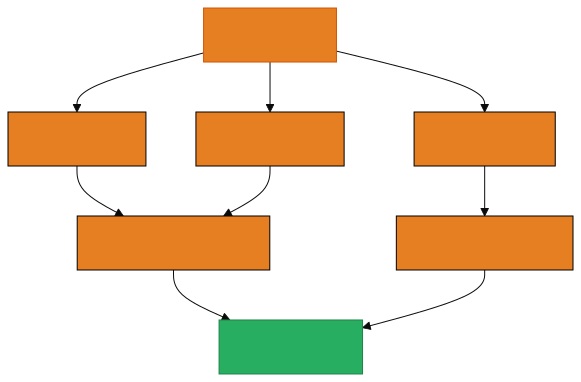

In [ ]:
// EXERCISE: Identify the layers in this workflow
import { displayMermaid } from "../lib/viz.ts";

const quizDiagram = `
%%{init: {'theme': 'base', 'themeVariables': { 'primaryColor': '#e67e22', 'primaryTextColor': '#fff'}}}%%
graph TD
    A["auth_user"] --> B["get_profile"]
    A --> C["get_settings"]
    A --> D["get_history"]
    B --> E["render_dashboard"]
    C --> E
    D --> F["generate_report"]
    E --> G["send_email"]
    F --> G
    
    style A fill:#e67e22,stroke:#d35400,color:#fff
    style G fill:#27ae60,stroke:#1e8449,color:#fff
`;

console.log("═".repeat(60));
console.log("         EXERCISE: Identify the Layers");
console.log("═".repeat(60));
console.log();
console.log("Look at the workflow below and answer:");
console.log();
console.log("1. How many layers will this workflow have?");
console.log("2. Which tasks can run in parallel?" );
console.log("3. What's the minimum execution time if each task takes 100ms?");
console.log();

await displayMermaid(quizDiagram);

════════════════════════════════════════════════════════════
         ANSWERS
════════════════════════════════════════════════════════════

1. Number of layers: 4

2. Parallel tasks by layer:
   Layer 0: [auth_user]
   Layer 1: [get_profile, get_settings, get_history] ← PARALLEL!
   Layer 2: [render_dashboard, generate_report] ← PARALLEL!
   Layer 3: [send_email]

3. Minimum time (if each task = 100ms):
   Sequential: 700ms (7 tasks × 100ms)
   Parallel:   400ms (4 layers × 100ms)
   Speedup:    1.75x

Layer visualization:


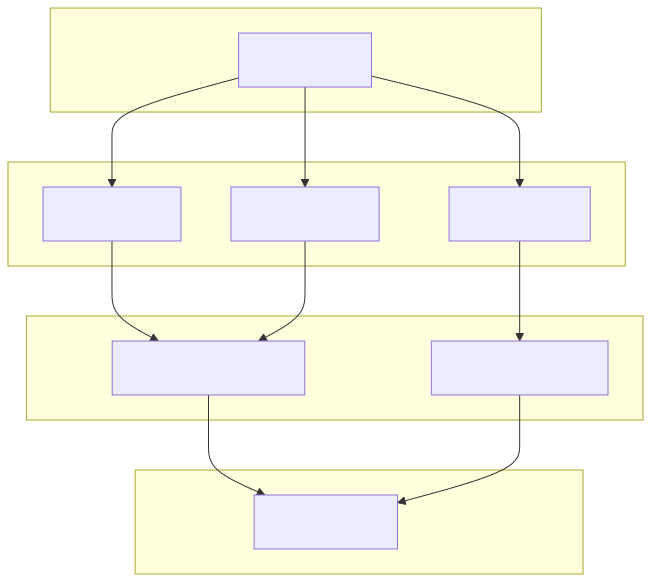

In [ ]:
// Run this cell to check your answers!
import { type DAGWorkflow, displayLayers } from "../lib/viz.ts";

const quizWorkflow: DAGWorkflow = {
  id: "quiz-workflow",
  tasks: [
    { id: "A", tool_name: "auth_user", dependencies: [] },
    { id: "B", tool_name: "get_profile", dependencies: ["A"] },
    { id: "C", tool_name: "get_settings", dependencies: ["A"] },
    { id: "D", tool_name: "get_history", dependencies: ["A"] },
    { id: "E", tool_name: "render_dashboard", dependencies: ["B", "C"] },
    { id: "F", tool_name: "generate_report", dependencies: ["D"] },
    { id: "G", tool_name: "send_email", dependencies: ["E", "F"] },
  ]
};

const quizLayers = topologicalSort(quizWorkflow);

console.log("═".repeat(60));
console.log("         ANSWERS");
console.log("═".repeat(60));
console.log();

console.log(`1. Number of layers: ${quizLayers.length}`);
console.log();

console.log("2. Parallel tasks by layer:");
for (let i = 0; i < quizLayers.length; i++) {
  const layer = quizLayers[i];
  const names = layer.map(t => t.tool_name).join(", ");
  const parallel = layer.length > 1 ? " ← PARALLEL!" : "";
  console.log(`   Layer ${i}: [${names}]${parallel}`);
}
console.log();

// If each task is 100ms
const seqTime = 7 * 100;  // 7 tasks × 100ms
const parTime = quizLayers.length * 100;  // number of layers × 100ms
console.log(`3. Minimum time (if each task = 100ms):`);
console.log(`   Sequential: ${seqTime}ms (7 tasks × 100ms)`);
console.log(`   Parallel:   ${parTime}ms (${quizLayers.length} layers × 100ms)`);
console.log(`   Speedup:    ${(seqTime/parTime).toFixed(2)}x`);

console.log();
console.log("Layer visualization:");
await displayLayers(quizLayers);

---

## Summary

### What We Learned

1. **DAGs** represent task dependencies without cycles
2. **Topological sort** organizes tasks into **layers**
3. Tasks in the same layer execute **in parallel**
4. **Fan-out** patterns enable maximum parallelization
5. **Linear chains** have no parallelization opportunity

### Key Takeaways

- More independent branches → greater speedup
- The critical path determines minimum execution time
- DAG analysis happens once, benefits every execution

---

## 🔗 Why This Matters for PML

You might wonder: **"Claude can already do parallel tool calls. Why do we need DAG execution?"**

The answer: **DAG execution enables structured tracing.**

| Without DAG | With DAG |
|-------------|----------|
| Tools called ad-hoc | Tools organized by layers |
| No dependency info | Explicit dependency graph |
| Hard to reproduce | Deterministic execution order |
| No learning possible | **Traces become reusable Capabilities** |

### The Key Insight

> DAG execution is not the goal - it's the **foundation**.
>
> The structured traces from DAG execution feed into the **Capability Learning** system (notebook 05).
> When a workflow succeeds, we save it as a reusable capability - complete with its dependency graph.

In notebook 05, you'll see how these execution traces become **procedural memory** - patterns the system can reuse without regenerating code.

---

**Next:** [04-code-execution.ipynb](./04-code-execution.ipynb) - Execute TypeScript safely in sandboxed workers